In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from monai.transforms import Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom, Resize
from sklearn.metrics import roc_curve, roc_auc_score
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2

In [2]:
device = torch.device("cuda:0")

In [3]:
dirCOVID = 'C:/Users/rrsoo/AdvancedStuff/Medical_AI/Images-processed-new/CT_COVID'
dirNonCOVID = 'C:/Users/rrsoo/AdvancedStuff/Medical_AI/Images-processed-new/CT_NonCOVID'

In [4]:
class CTCOVIDDataset(Dataset):
    def __init__(self, dirCOVID, dirNonCOVID, transforms, data):
        self.IMG_SIZE = 224
        self.valSplit = 0.1
        self.COVID = dirCOVID
        self.NonCOVID = dirNonCOVID
        self.LABELS = {self.NonCOVID:0, self.COVID:1}
        self.training_data = []
        
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                path = os.path.join(label, f)
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                self.training_data.append([np.array(img), self.LABELS[label]])
                
        np.random.shuffle(self.training_data)
        self.valSize = int(self.valSplit*len(self.training_data))
        
        self.X_val = torch.Tensor([i[0] for i in self.training_data[0:self.valSize]]).view(-1, 3, 224, 224)
        self.X_val/=255
        self.y_val = torch.Tensor([i[1] for i in self.training_data[0:self.valSize]])
        
        self.X_test = torch.Tensor([i[0] for i in self.training_data[self.valSize: self.valSize+self.valSize]]).view(-1, 3, 224, 224)
        self.X_test/=255
        self.y_test = torch.Tensor([i[1] for i in self.training_data[self.valSize: self.valSize+self.valSize]])
        
        self.X_train = torch.Tensor([i[0] for i in self.training_data[self.valSize+self.valSize:]]).view(-1, 3, 224, 224)
        self.X_train/=255
        self.y_train = torch.Tensor([i[1] for i in self.training_data[self.valSize+self.valSize:]])
        
        self.transforms = transforms
        self.data = data

    def __len__(self):
        
        if self.data == 'train':
            return self.y_train.shape[0]
        elif self.data == 'val':
            return self.y_val.shape[0]
        elif self.data == 'test':
            return self.y_test.shape[0]

    def __getitem__(self, idx):
        
        if self.data == 'train':
            return self.X_train[idx], self.y_train[idx]
        elif self.data == 'val':
            return self.X_val[idx], self.y_val[idx]
        elif self.data == 'test':
            return self.X_test[idx], self.y_test[idx]


In [5]:
#Tune the transforms
train_transforms = transforms.Compose([
    LoadPNG(),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(degrees=15, prob=0.5),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    Resize(spatial_size=(224, 224)),
    ToTensor()
])

val_transforms = Compose([
    LoadPNG(),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

In [6]:
train_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = train_transforms, data = 'train')
train_loader = DataLoader(train_ds, batch_size=20, shuffle=True) #Tune batch size

val_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = val_transforms, data = 'val')
val_loader = DataLoader(val_ds, batch_size=20, shuffle=True)

test_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = val_transforms, data = 'test')
test_loader = DataLoader(test_ds, batch_size=20, shuffle=True)

100%|██████████| 346/346 [00:01<00:00, 322.28it/s]


In [7]:
print("Training Data Size:", train_ds.__len__())
print("Validation Data Size:", val_ds.__len__())
print("Testing Data Size:", test_ds.__len__())

Training Data Size: 595
Validation Data Size: 74
Testing Data Size: 74


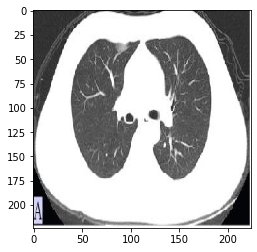

In [8]:
img1 = 0
for batch in train_loader:
    img = batch
plt.imshow(img[0][0].view(224, 224, 3))

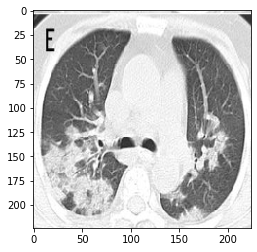

In [9]:
img2 = 0
for batch in val_loader:
    img = batch
plt.imshow(img[0][0].view(224, 224, 3))

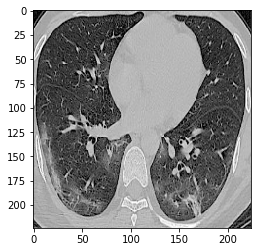

In [10]:
img = 0
for batch in test_loader:
    img = batch
plt.imshow(img[0][0].view(224, 224, 3))

In [11]:
def validation(model, val_loader, criterion):
    test_loss = 0
    total = 0
    correct = 0
    for data in tqdm(val_loader):
        X, y = data[0].to(device), data[1].to(device)
        output = model(X)
        test_loss += criterion(output, y.long()).item()
        
        for index, i in enumerate(output):
            if torch.argmax(i) == y[index]:
                correct+=1
            total+=1
                
    accuracy = correct/total
    
    return test_loss, accuracy

In [12]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs):
    plot_train_loss = []
    plot_val_loss = []
    plot_train_acc = []
    plot_val_acc = []
    for epoch in range(epochs):
        model.train()
        total = 0
        correct = 0
        train_loss = 0
        for data in tqdm(train_loader):
            X, y = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y.long())
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            for index, i in enumerate(output):
                if torch.argmax(i) == y[index]:
                    correct+=1
                total+=1
                
        model.eval()
                
        with torch.no_grad():
            val_loss, val_acc = validation(model, val_loader, criterion)
                    
        train_acc = correct/total
        
        print("Training Loss:", train_loss)
        plot_train_loss.append(train_loss)
        
        print("Training Accuracy:", train_acc)
        plot_train_acc.append(train_acc)
        
        print("Validation Loss:", val_loss)
        plot_val_loss.append(val_loss)
        
        print("Validation Accuracy:", val_acc)
        plot_val_acc.append(val_acc)
        
        model.train()
    
    plot_train_loss = np.array(plot_train_loss) 
    plot_val_loss = np.array(plot_val_loss)
    plot_train_acc = np.array(plot_train_acc)
    plot_val_acc = np.array(plot_val_acc)
    
    return plot_train_loss, plot_val_loss, plot_train_acc, plot_val_acc
        

In [19]:
model = torchvision.models.vgg16(pretrained = True).to(device)
#model = torchvision.models.densenet121(pretrained = True).to(device)
#model = torchvision.models.resnet50(pretrained = True).to(device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
for param in model.parameters():
    param.requires_grad = False

#Tune the number of hidden layers, hidden units, kernel_initializer, add batch norm
'''
VGG16 model classifier layers
'''
layers = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 512)),
    ('activation1', nn.ReLU()),
    ('dropout1', nn.Dropout()),
    ('fc2', nn.Linear(512, 256)),
    ('activation2', nn.ReLU()),
    ('dropout2', nn.Dropout()),
    ('fc3', nn.Linear(256, 128)),
    ('activation3', nn.ReLU()),
    ('dropout3', nn.Dropout()),
    ('fc4', nn.Linear(128, 2)),
    ('out', nn.Sigmoid())
    
])).to(device)

model.classifier = layers


'''
ResNet model classifier layers

layers = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2048, 512)),
     ('activation1', nn.ReLU()),
     ('fc2', nn.Linear(512, 2)),
     ('output', nn.Sigmoid())])).to(device)
model.fc = layers
'''

optimizer = optim.Adam(model.parameters()) #Tune the learning rate
criterion = nn.CrossEntropyLoss()

plot_train_loss, plot_val_loss, plot_train_acc, plot_val_acc = train(model, train_loader, val_loader, optimizer, criterion, 15)

  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 20.92343407869339
Training Accuracy: 0.5277310924369748
Validation Loss: 2.7255603075027466
Validation Accuracy: 0.5675675675675675


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 20.631107211112976
Training Accuracy: 0.5663865546218487
Validation Loss: 2.6534050703048706
Validation Accuracy: 0.5675675675675675


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 20.622632026672363
Training Accuracy: 0.5781512605042017
Validation Loss: 2.7523435950279236
Validation Accuracy: 0.7027027027027027


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 20.069809675216675
Training Accuracy: 0.5882352941176471
Validation Loss: 2.3947720527648926
Validation Accuracy: 0.6486486486486487


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 18.052799999713898
Training Accuracy: 0.6823529411764706
Validation Loss: 2.4527785778045654
Validation Accuracy: 0.6621621621621622


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 17.677273273468018
Training Accuracy: 0.6991596638655462
Validation Loss: 2.1514596343040466
Validation Accuracy: 0.7837837837837838


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 16.329726189374924
Training Accuracy: 0.7512605042016807
Validation Loss: 1.960936963558197
Validation Accuracy: 0.7972972972972973


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 15.61000806093216
Training Accuracy: 0.7848739495798319
Validation Loss: 1.9183966517448425
Validation Accuracy: 0.8378378378378378


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 14.585618823766708
Training Accuracy: 0.8285714285714286
Validation Loss: 2.178412228822708
Validation Accuracy: 0.7567567567567568


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 14.196006506681442
Training Accuracy: 0.838655462184874
Validation Loss: 1.7461871802806854
Validation Accuracy: 0.8783783783783784


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 13.630226761102676
Training Accuracy: 0.8521008403361344
Validation Loss: 1.7431191802024841
Validation Accuracy: 0.8648648648648649


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 14.569020956754684
Training Accuracy: 0.8168067226890756
Validation Loss: 1.7457359433174133
Validation Accuracy: 0.8783783783783784


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 13.545677334070206
Training Accuracy: 0.8554621848739495
Validation Loss: 2.049389064311981
Validation Accuracy: 0.7567567567567568


  0%|          | 0/30 [00:00<?, ?it/s]

Training Loss: 14.251259297132492
Training Accuracy: 0.8352941176470589
Validation Loss: 2.0846183001995087
Validation Accuracy: 0.7972972972972973


100%|██████████| 4/4 [00:01<00:00,  3.98it/s]

Training Loss: 13.781418323516846
Training Accuracy: 0.8521008403361344
Validation Loss: 1.8195934891700745
Validation Accuracy: 0.8513513513513513


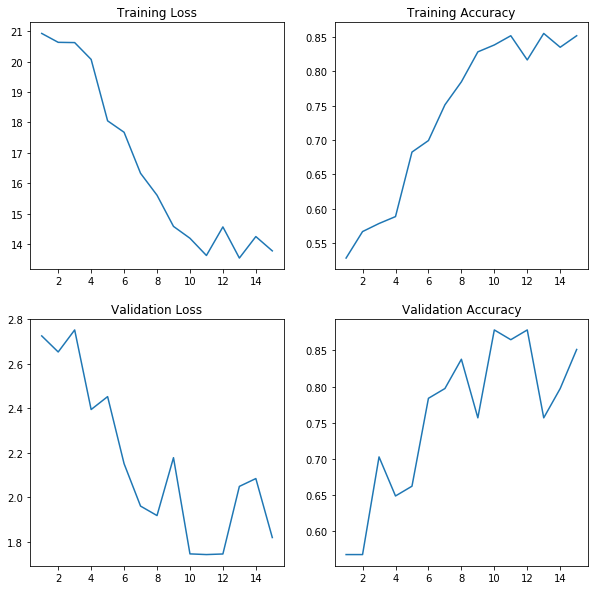

In [21]:
def plot_train_val(num_epochs, fig_size):
    plot_epochs = np.array([i for i in range(1, num_epochs+1)])
    fig, axs = plt.subplots(2, 2)
    
    axs[0, 0].plot(plot_epochs, plot_train_loss)
    axs[0, 0].set_title("Training Loss")
    
    axs[1, 0].plot(plot_epochs, plot_val_loss)
    axs[1, 0].set_title("Validation Loss")
    
    axs[0, 1].plot(plot_epochs, plot_train_acc)
    axs[0, 1].set_title("Training Accuracy")
    
    axs[1, 1].plot(plot_epochs, plot_val_acc)
    axs[1, 1].set_title("Validation Accuracy")
    
    fig.set_figheight(fig_size[0])
    fig.set_figwidth(fig_size[1])
    
plot_train_val(15, (10, 10))

In [22]:
def test(model, test_loader, criterion):
    y_proba = []
    y_truth = []
    test_loss = 0
    total = 0
    correct = 0
    for data in tqdm(test_loader):
        X, y = data[0].to(device), data[1].to(device)
        output = model(X)
        test_loss += criterion(output, y.long()).item()
        for index, i in enumerate(output):
            y_proba.append(i[1])
            y_truth.append(y[index])
            if torch.argmax(i) == y[index]:
                correct+=1
            total+=1
                
    accuracy = correct/total
    
    y_proba_out = np.array([float(y_proba[i]) for i in range(len(y_proba))])
    y_truth_out = np.array([float(y_truth[i]) for i in range(len(y_truth))])
    
    return test_loss, accuracy, y_proba_out, y_truth_out

In [23]:
loss, acc, y_proba, y_truth = test(model, test_loader, criterion)
acc

100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


0.7837837837837838

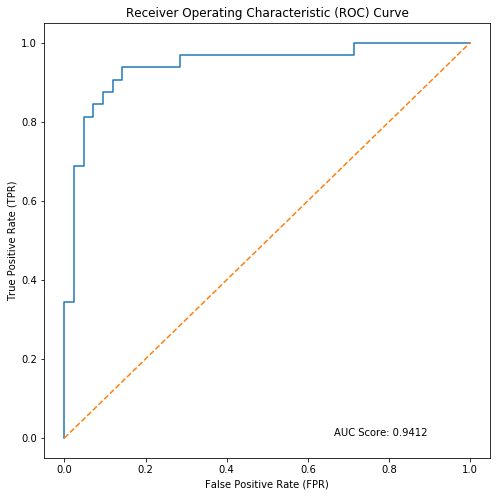

In [24]:
def plot_ROCAUC_curve(y_truth, y_proba, fig_size):
    fpr, tpr, threshold = roc_curve(y_truth, y_proba)
    auc_score = roc_auc_score(y_truth, y_proba)
    txt_box = "AUC Score: " + str(round(auc_score, 4))
    plt.figure(figsize=fig_size)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'--')
    plt.annotate(txt_box, xy=(0.65, 0.05), xycoords='axes fraction')
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    
plot_ROCAUC_curve(y_truth, y_proba, (8, 8))